<a href="https://colab.research.google.com/github/peachiestao/peachiestao.github.io/blob/main/DTI_5125_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Choose Data




In [5]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
import random
from google.colab import files

# Define the categories and their updated search queries
categories = {
    "ML for improving seasonal weather forecasts": "ML for improving seasonal weather forecasts",
    "Forecasting renewable energy availability": "Forecasting renewable energy availability",
    "ML-based early warning systems for hurricanes": "machine learning hurricane prediction",
    "Predicting carbon footprints of cities or industries": "carbon footprint prediction cities industries",
    "ML for predicting climate change impacts on agriculture": "machine learning climate change agriculture"
}

# arXiv API endpoint
url = "http://export.arxiv.org/api/query"

# Function to search for documents
def search_documents(query, start=0, max_results=200):
    params = {
        "search_query": query,
        "start": start,
        "max_results": max_results
    }
    response = requests.get(url, params=params)
    if response.status_code != 200:
        print(f"Error {response.status_code}: {response.text}")
        return None
    return response.content


# Function to extract ~100-word samples from documents
def extract_samples(xml_data):
    if xml_data is None:
        return []
    root = ET.fromstring(xml_data)
    samples = []
    for entry in root.findall("{http://www.w3.org/2005/Atom}entry"):
        title = entry.find("{http://www.w3.org/2005/Atom}title").text
        abstract = entry.find("{http://www.w3.org/2005/Atom}summary").text
        text = title + " " + abstract
        words = text.split()
        segment_length = 100
        if len(words) >= segment_length:
            random_start = random.randint(0, len(words) - segment_length)
            sample = " ".join(words[random_start : random_start + segment_length])
            samples.append(sample)
    return samples

# Function to create DataFrame with partitions
def create_dataframe(all_samples):
    labels = []
    partitions = []
    for category, samples in all_samples.items():
        for sample in samples:
            labels.append(category)
            partitions.append(sample)
    df = pd.DataFrame({'category': labels, 'sample': partitions})
    return df

# Main function to retrieve and process documents
def retrieve_and_process_documents():
    all_samples = {}
    for category, query in categories.items():
        all_category_samples = []
        start = 0
        while len(all_category_samples) < 200:
            xml_data = search_documents(query, start=start, max_results=200)
            samples = extract_samples(xml_data)
            if not samples:
                break
            all_category_samples.extend(samples)
            start += 200
        # If not enough samples, use a broader query as a fallback
        if len(all_category_samples) < 200:
            broad_query = "machine learning " + " ".join(query.split()[:-1])
            start = 0
            while len(all_category_samples) < 200:
                xml_data = search_documents(broad_query, start=start, max_results=200)
                samples = extract_samples(xml_data)
                if not samples:
                    break
                all_category_samples.extend(samples)
                start += 200
        all_samples[category] = all_category_samples[:200]  # Ensure only 200 samples per category
    return all_samples

# Run the main function and create DataFrame
all_samples = retrieve_and_process_documents()
df = create_dataframe(all_samples)

# Check the first few rows
print(df.head())

# Save the DataFrame to CSV
filename = 'research_papers.csv'
df.to_csv(filename, index=False)

# Download the CSV file
#files.download(filename)


                                      category  \
0  ML for improving seasonal weather forecasts   
1  ML for improving seasonal weather forecasts   
2  ML for improving seasonal weather forecasts   
3  ML for improving seasonal weather forecasts   
4  ML for improving seasonal weather forecasts   

                                              sample  
0  models from the Subseasonal Experiment (SubX) ...  
1  its skill is only about one day behind both SO...  
2  becoming increasingly important for a range of...  
3  to the performance of these methods for extrem...  
4  Highlands. We generate ensemble inflow forecas...  


 Data Preparation


In [6]:
import pandas as pd
from nltk.corpus import stopwords
import re
from google.colab import files

# Ensure you have the NLTK stopwords corpus
import nltk
nltk.download('stopwords')

# Function to clean text and remove stopwords
def clean_text(text):
    stop_words = set(stopwords.words('english'))
    # Remove non-alphanumeric characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    # Remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

# Function to perform data cleaning
def clean_dataset(file_path):

        # Read the raw dataset from the CSV file
        df = pd.read_csv(file_path)
        # Add book labels starting from 'a'
        labels = [chr(97 + (i % 5)) for i in range(len(df))]
        df['book_label'] = labels
        # Clean text data
        df['clean_sample'] = df['sample'].apply(clean_text)

        return df

# Perform data cleaning on the generated raw dataset
cleaned_df = clean_dataset('research_papers.csv')

if cleaned_df is not None:
    # Save the cleaned DataFrame to a new CSV file
    cleaned_file_path = 'cleaned_research_papers.csv'
    cleaned_df.to_csv(cleaned_file_path, index=False)

    # Download the cleaned CSV file
    #files.download(cleaned_file_path)

    # Check the first few rows of the cleaned data
    print("Cleaned Data Sample:")
    print(cleaned_df.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cleaned Data Sample:
                                      category  \
0  ML for improving seasonal weather forecasts   
1  ML for improving seasonal weather forecasts   
2  ML for improving seasonal weather forecasts   
3  ML for improving seasonal weather forecasts   
4  ML for improving seasonal weather forecasts   

                                              sample book_label  \
0  models from the Subseasonal Experiment (SubX) ...          a   
1  its skill is only about one day behind both SO...          b   
2  becoming increasingly important for a range of...          c   
3  to the performance of these methods for extrem...          d   
4  Highlands. We generate ensemble inflow forecas...          e   

                                        clean_sample  
0  models subseasonal experiment subx project ssf...  
1  skill one day behind sota ml forecast models s...  
2  becoming increasingly important range socioeco...  
3  performance methods extreme event severities r...  


Part 2 - Feature Engineering

In [7]:
# Bag of words
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
bag_of_words = vectorizer.fit_transform(cleaned_df['clean_sample'])

df_bag_of_words = pd.DataFrame(bag_of_words.toarray(),columns=vectorizer.get_feature_names_out())
print(df_bag_of_words.shape)
print(df_bag_of_words.columns)

(1000, 8774)
Index(['abatement', 'abide', 'abilities', 'ability', 'ablation', 'able',
       'abruptly', 'absence', 'absent', 'absolute',
       ...
       'youngs', 'yr', 'yuan', 'zero', 'zeroloss', 'zeroshot', 'zonal', 'zone',
       'zonebased', 'zones'],
      dtype='object', length=8774)


In [8]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
tf_idf = vectorizer.fit_transform(cleaned_df['clean_sample'].values.astype('U'))

df_tf_idf = pd.DataFrame(tf_idf.toarray(),columns=vectorizer.get_feature_names_out())
print(df_tf_idf.shape)
print(df_tf_idf.columns)

(1000, 8774)
Index(['abatement', 'abide', 'abilities', 'ability', 'ablation', 'able',
       'abruptly', 'absence', 'absent', 'absolute',
       ...
       'youngs', 'yr', 'yuan', 'zero', 'zeroloss', 'zeroshot', 'zonal', 'zone',
       'zonebased', 'zones'],
      dtype='object', length=8774)


In [9]:
# N-gram (bigram, trigram)
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2,3))
ngram = vectorizer.fit_transform(cleaned_df['clean_sample'])

df_ngram = pd.DataFrame(ngram.toarray(),columns=vectorizer.get_feature_names_out())
print(df_ngram.shape)
print(df_ngram.columns)

(1000, 107023)
Index(['abatement costs', 'abatement costs north', 'abide government',
       'abide government regulation', 'abilities method',
       'abilities method offers', 'abilities rags', 'abilities rags efficient',
       'ability adjust', 'ability adjust trading',
       ...
       'zones evacuated', 'zones evacuated residences', 'zones geographical',
       'zones geographical types', 'zones latetype', 'zones latetype dwarf',
       'zones may', 'zones may improve', 'zones various',
       'zones various weather'],
      dtype='object', length=107023)


Model Training(TF-IDF)

Training SVM...
SVM Classification Report(TF-IDF):
                                                         precision    recall  f1-score   support

              Forecasting renewable energy availability       0.91      1.00      0.95        29
            ML for improving seasonal weather forecasts       0.94      0.79      0.86        19
ML for predicting climate change impacts on agriculture       0.83      0.95      0.88        20
          ML-based early warning systems for hurricanes       1.00      0.75      0.86        12
   Predicting carbon footprints of cities or industries       0.90      0.90      0.90        20

                                               accuracy                           0.90       100
                                              macro avg       0.91      0.88      0.89       100
                                           weighted avg       0.91      0.90      0.90       100



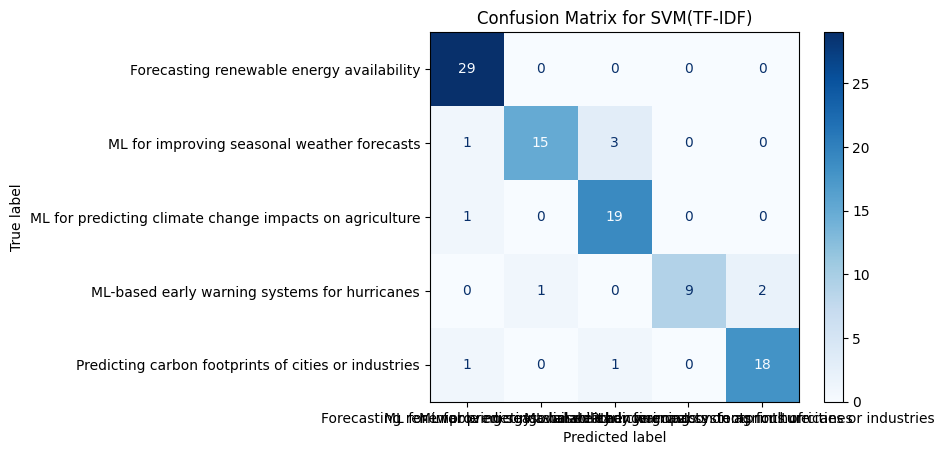

Training Random Forest...
Random Forest Classification Report(TF-IDF):
                                                         precision    recall  f1-score   support

              Forecasting renewable energy availability       0.90      0.93      0.92        29
            ML for improving seasonal weather forecasts       0.80      0.84      0.82        19
ML for predicting climate change impacts on agriculture       0.90      0.90      0.90        20
          ML-based early warning systems for hurricanes       0.89      0.67      0.76        12
   Predicting carbon footprints of cities or industries       0.90      0.95      0.93        20

                                               accuracy                           0.88       100
                                              macro avg       0.88      0.86      0.86       100
                                           weighted avg       0.88      0.88      0.88       100



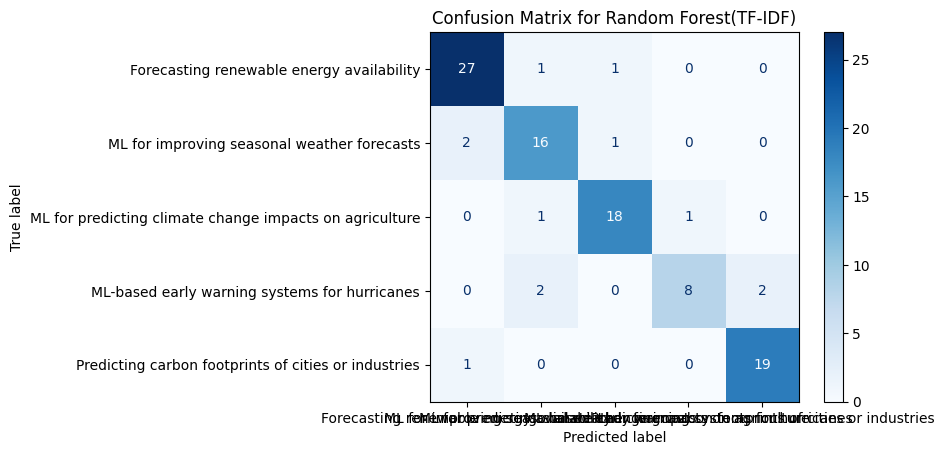

Training Naïve Bayes...
Naïve Bayes Classification Report(TF-IDF):
                                                         precision    recall  f1-score   support

              Forecasting renewable energy availability       0.90      0.97      0.93        29
            ML for improving seasonal weather forecasts       0.85      0.89      0.87        19
ML for predicting climate change impacts on agriculture       0.95      0.90      0.92        20
          ML-based early warning systems for hurricanes       1.00      1.00      1.00        12
   Predicting carbon footprints of cities or industries       1.00      0.90      0.95        20

                                               accuracy                           0.93       100
                                              macro avg       0.94      0.93      0.94       100
                                           weighted avg       0.93      0.93      0.93       100



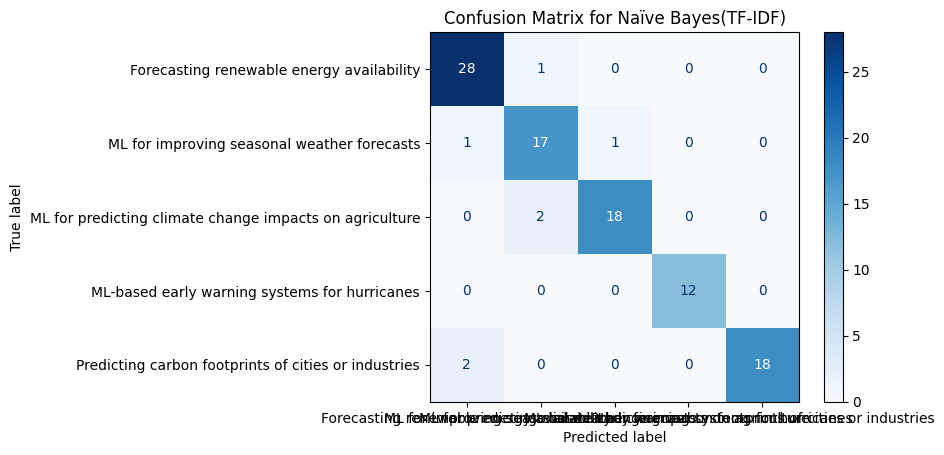

Training k-Nearest Neighbors...
k-Nearest Neighbors Classification Report(TF-IDF):
                                                         precision    recall  f1-score   support

              Forecasting renewable energy availability       0.83      0.83      0.83        29
            ML for improving seasonal weather forecasts       0.75      0.79      0.77        19
ML for predicting climate change impacts on agriculture       0.83      0.95      0.88        20
          ML-based early warning systems for hurricanes       0.71      0.83      0.77        12
   Predicting carbon footprints of cities or industries       1.00      0.70      0.82        20

                                               accuracy                           0.82       100
                                              macro avg       0.82      0.82      0.81       100
                                           weighted avg       0.83      0.82      0.82       100



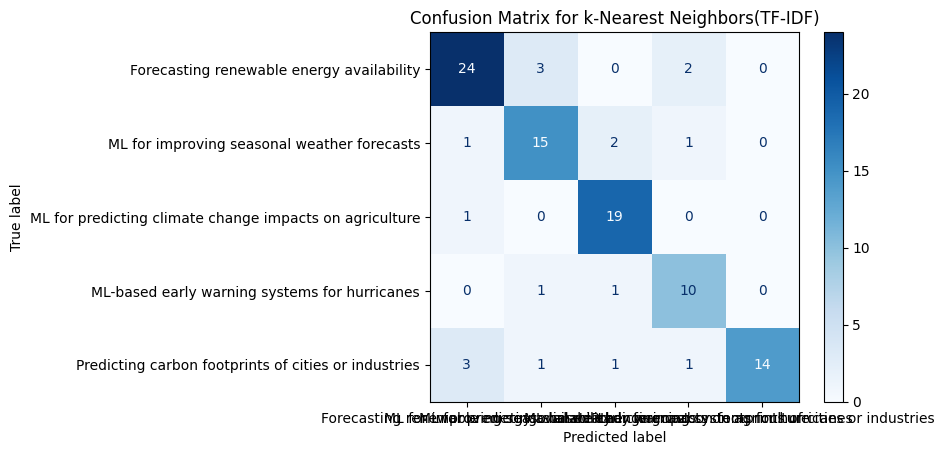

Training SGD...
SGD Classification Report(TF-IDF):
                                                         precision    recall  f1-score   support

              Forecasting renewable energy availability       0.88      1.00      0.94        29
            ML for improving seasonal weather forecasts       1.00      0.79      0.88        19
ML for predicting climate change impacts on agriculture       0.86      0.95      0.90        20
          ML-based early warning systems for hurricanes       1.00      0.83      0.91        12
   Predicting carbon footprints of cities or industries       0.90      0.90      0.90        20

                                               accuracy                           0.91       100
                                              macro avg       0.93      0.89      0.91       100
                                           weighted avg       0.92      0.91      0.91       100



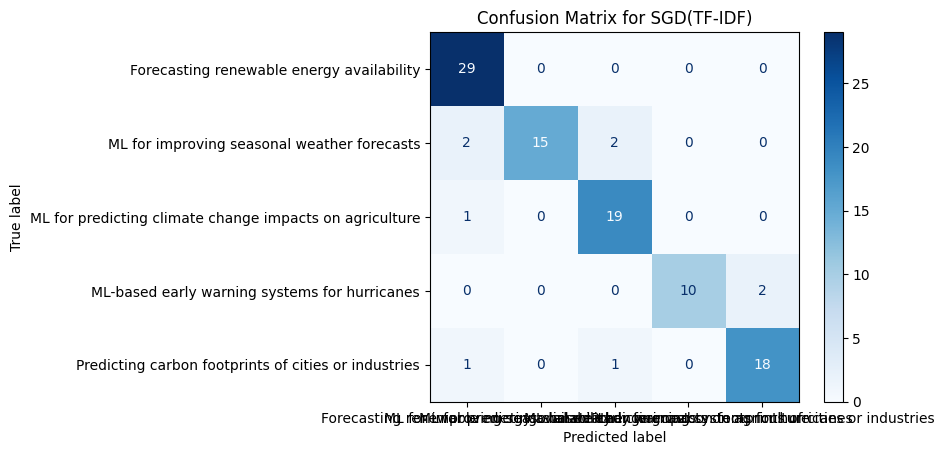

Best Classifier: Naïve Bayes
Best Accuracy: 0.9300


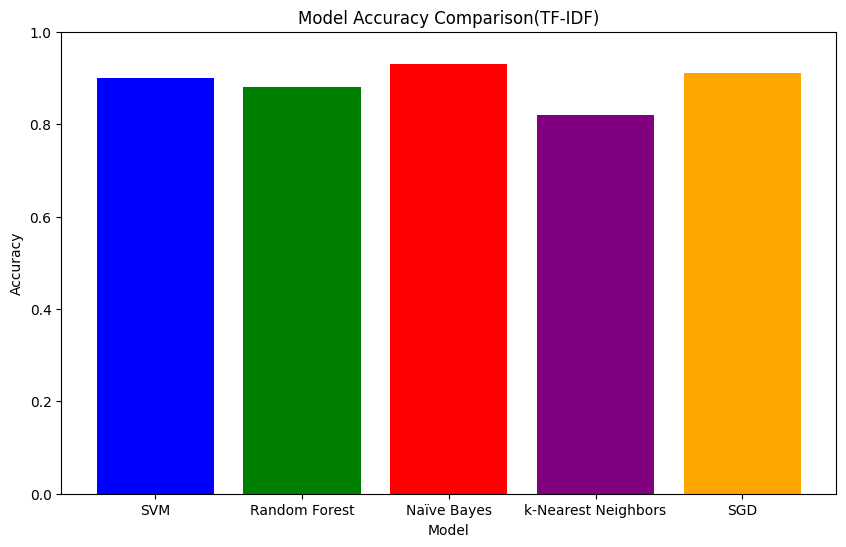

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(tf_idf, df['category'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define models
models = {
    "SVM": SVC(kernel='linear'),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Naïve Bayes": MultinomialNB(),
    "k-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "SGD": SGDClassifier(loss='log_loss', max_iter=1000, random_state=42),
}

accuracy_scores = {}

# Train and Evaluate Models
for model_name, model in models.items():
    print(f"Training {model_name}...")
    scores = cross_val_score(model, X_train, y_train, cv=10)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores[model_name] = accuracy

    print(f"{model_name} Classification Report(TF-IDF):")
    print(classification_report(y_test, y_pred))


    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {model_name}(TF-IDF)")
    plt.show()

# Identify and Print the Best Model
best_model_name = max(accuracy_scores, key=accuracy_scores.get)
best_accuracy = accuracy_scores[best_model_name]
print(f"Best Classifier: {best_model_name}")
print(f"Best Accuracy: {best_accuracy:.4f}")

# Bar Chart Visualization
plt.figure(figsize=(10, 6))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color=['blue', 'green', 'red', 'purple', 'orange', 'brown'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison(TF-IDF)')
plt.ylim(0, 1)
plt.show()



# Save results
df.to_csv("prepared_text_samples.csv", index=False)

Model Training(BERT)

Error Analysis

In [11]:
import numpy as np

best_model = models[best_model_name]

prediction = best_model.predict(X_test)

miss_predicts = pd.DataFrame(np.transpose([prediction[prediction!=y_test],y_test[prediction!=y_test]]),columns=["Predict","True"])
class_names = y_test.unique()

top_15_words = []
for name in class_names:
    class_instances = X_test[prediction==name].toarray()
    class_word_feq = class_instances.sum(axis=0)
    class_word_index_sort = class_word_feq.argsort()[::-1][:15]
    top_15_words.append(df_tf_idf.columns[class_word_index_sort])

In [12]:
# miss predictions
miss_predicts.value_counts()

,,count
Predict,True,
Forecasting renewable energy availability,Predicting carbon footprints of cities or industries,2
ML for improving seasonal weather forecasts,ML for predicting climate change impacts on agriculture,2
Forecasting renewable energy availability,ML for improving seasonal weather forecasts,1
ML for improving seasonal weather forecasts,Forecasting renewable energy availability,1
ML for predicting climate change impacts on agriculture,ML for improving seasonal weather forecasts,1


In [ ]:
pd.DataFrame(np.transpose(top_15_words),columns=class_names)

,ML-based early warning systems for hurricanes,ML for predicting climate change impacts on agriculture,Forecasting renewable energy availability,ML for improving seasonal weather forecasts,Predicting carbon footprints of cities or industries
0,road,climate,energy,weather,carbon
1,hurricane,agricultural,renewable,seasonal,footprint
2,wave,agriculture,forecasting,forecast,emission
3,model,models,power,models,emissions
4,consensus,data,wind,forecasts,data
5,learning,learning,generation,forecasting,steel
6,sketches,moisture,load,model,cities
7,track,rd,grid,machine,ride
8,models,processes,forecast,ml,energy
9,travel,deep,data,prediction,relatedness


Visualization

Error Analysis

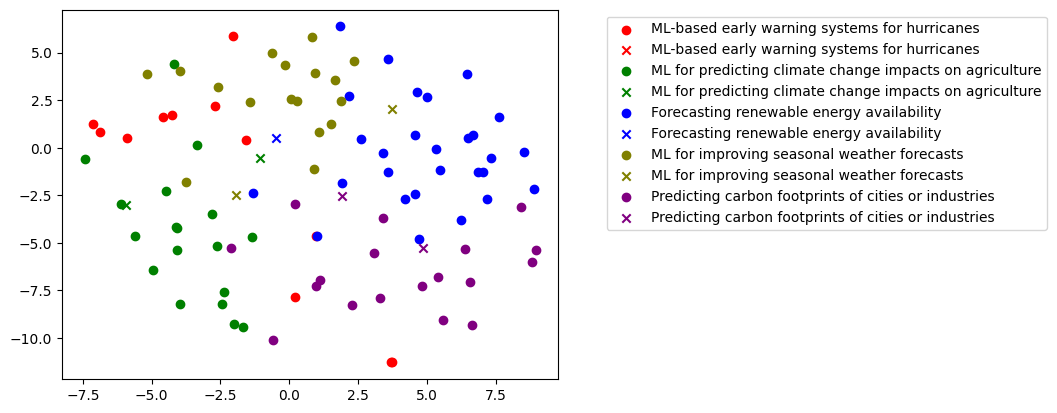

In [13]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

tsne = TSNE(early_exaggeration=1)
downscale = tsne.fit_transform(X_test.toarray())

colors =['red','green','blue','olive','purple']
for i,name in enumerate(class_names):
    correct_pred = downscale[(y_test==name) & (prediction==y_test)]
    miss_pred = downscale[(y_test==name) & (prediction!=y_test)]

    plt.scatter(correct_pred[:,0],correct_pred[:,1],label=name,color=colors[i],marker='o')
    plt.scatter(miss_pred[:,0],miss_pred[:,1],label=name,c=colors[i],marker='x')


plt.legend(loc="upper right",bbox_to_anchor=(2,1))

We transform the tf-idf into a 2d T-sne plot. In T-sne plot, same color means the same class, circle(O) means correct predictions and cross(X) means miss predictions.
we notice that most of miss-predictions are in the edge between two classes. Espectially they are in the upper right, Olive class and blue class. These two classes have many overlap areas.

Hardship Analysis

In [14]:
import pandas as pd
import random
import re
from nltk.corpus import stopwords

# Ensure you have the NLTK stopwords corpus
import nltk
nltk.download('stopwords')

# Load the cleaned dataset
df = pd.read_csv('cleaned_research_papers.csv')

# Function to truncate text to a specified number of words
def truncate_text(text, num_words=50):
    words = text.split()[:num_words]
    return " ".join(words)

# Truncate the text samples to 50 words
df['truncated_sample'] = df['clean_sample'].apply(lambda x: truncate_text(x, num_words=50))

# Add random author names and publication dates as noise
author_names = ['Alice Smith', 'Bob Johnson', 'Charlie Brown', 'David Wilson', 'Emma Davis']
publication_years = [2018, 2019, 2020, 2021, 2022]

df['author'] = [random.choice(author_names) for _ in range(len(df))]
df['publication_year'] = [random.choice(publication_years) for _ in range(len(df))]

# Save the modified dataset to a new CSV file
hardship_file_path = 'hardship_research_papers.csv'
df.to_csv(hardship_file_path, index=False)

# Download the modified CSV file
from google.colab import files
#files.download(hardship_file_path)

# Check the first few rows of the modified data
print("Hardship Data Sample:")
print(df.head())


Hardship Data Sample:
                                      category  \
0  ML for improving seasonal weather forecasts   
1  ML for improving seasonal weather forecasts   
2  ML for improving seasonal weather forecasts   
3  ML for improving seasonal weather forecasts   
4  ML for improving seasonal weather forecasts   

                                              sample book_label  \
0  models from the Subseasonal Experiment (SubX) ...          a   
1  its skill is only about one day behind both SO...          b   
2  becoming increasingly important for a range of...          c   
3  to the performance of these methods for extrem...          d   
4  Highlands. We generate ensemble inflow forecas...          e   

                                        clean_sample  \
0  models subseasonal experiment subx project ssf...   
1  skill one day behind sota ml forecast models s...   
2  becoming increasingly important range socioeco...   
3  performance methods extreme event severities r.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
import pandas as pd
import random
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Ensure you have the NLTK stopwords corpus
nltk.download('stopwords')

# Load the hardship dataset
df = pd.read_csv('hardship_research_papers.csv')

# Vectorize the text samples using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['truncated_sample'])

# Convert the added noise features to numerical values
df['author'] = pd.Categorical(df['author']).codes
df['publication_year'] = pd.Categorical(df['publication_year']).codes
additional_features = df[['author', 'publication_year']].values

# Concatenate TF-IDF features and additional features
import numpy as np
X = np.hstack((X.toarray(), additional_features))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['category'], test_size=0.2, random_state=42)

# Define classifiers
classifiers = {
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Naïve Bayes': MultinomialNB(),
    'k-NN': KNeighborsClassifier(),
    'SGD': SGDClassifier()
}

# Perform 10-fold cross-validation and evaluate performance metrics
results = {}
skf = StratifiedKFold(n_splits=10)
for name, clf in classifiers.items():
    accuracy = cross_val_score(clf, X_train, y_train, cv=skf, scoring='accuracy')
    precision = cross_val_score(clf, X_train, y_train, cv=skf, scoring='precision_weighted')
    recall = cross_val_score(clf, X_train, y_train, cv=skf, scoring='recall_weighted')
    f1 = cross_val_score(clf, X_train, y_train, cv=skf, scoring='f1_weighted')

    results[name] = {
        'Accuracy': accuracy.mean(),
        'Precision': precision.mean(),
        'Recall': recall.mean(),
        'F1 Score': f1.mean()
    }

# Print results
for name, metrics in results.items():
    print(f"{name} Results:")
    for metric, score in metrics.items():
        print(f"{metric}: {score:.4f}")
    print("\n")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

SVM Results:
Accuracy: 0.2750
Precision: 0.3549
Recall: 0.2750
F1 Score: 0.2587


Random Forest Results:
Accuracy: 0.8450
Precision: 0.8473
Recall: 0.8225
F1 Score: 0.8346


Naïve Bayes Results:
Accuracy: 0.7538
Precision: 0.8080
Recall: 0.7538
F1 Score: 0.7433


k-NN Results:
Accuracy: 0.5162
Precision: 0.5419
Recall: 0.5162
F1 Score: 0.5119


SGD Results:
Accuracy: 0.7962
Precision: 0.8231
Recall: 0.7638
F1 Score: 0.7612


